In [1]:
# default_exp data

Since I intend on modifying the model and retraining on the data, it's better to precompute the synthetic training images since generating them in realtime is slow. Looking at the validation error curve for the second attempt:

![title](https://i.imgur.com/yi9Lo0d.png)

A batch size of 28 was used, with 20 batches per checkpoint, which results in 560 images per checkpoint. Since we trained for 500 checkpoints, this results in 280,000 images.

Note that this was run on my desktop where the data is stored and training is done. 

# Pre-generate Images

In [2]:
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from IPython.core.debugger import set_trace

import numpy as np
import torch
from torch import nn

In [3]:
import sys
sys.path.append('../fiducial_detect/')

In [4]:
from fiducial_detect.data import *
from fiducial_detect.models import *

I use the same transforms as attempt 2

In [5]:
tfms_trn = Compose([Resize((512, 384)), 
                    Normalize((0, 1), (-1, 1)),
                    RandomContrast((0.5, 1.5), 1, 0.33),
                    RandomBrightness((-0.5, 0.5), 0, 0.33),
                    RandomBlur((0, 1.5), 0.50, 0.50),
                    Random(Noise((-0.25, 0.25), 0, 0.1), 0.9),
                    Random(RandomGrad((-0.5, 0.5))     , 0.9),
                    Clip((-1,1)),
                    ToTensor()])

ds_trn = SyntheticMaskDataSet(dir_random_bg=Path('../fiducial_detect/data/backgrounds'), tfms=tfms_trn)

Show an example

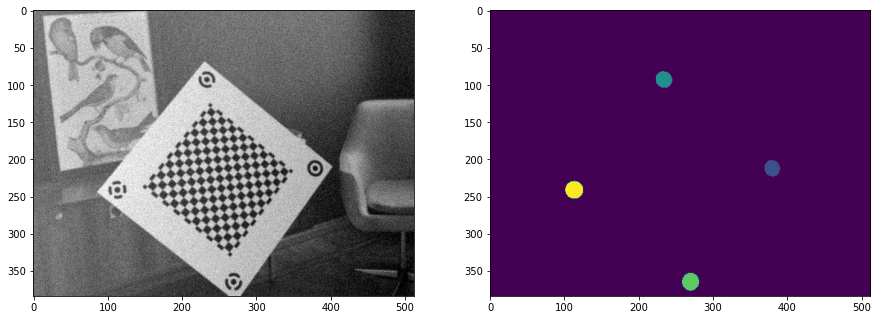

In [6]:
X, y = next(ds_trn)
_, axs = plt.subplots(1,2, figsize=(15, 7))
axs[0].imshow(X.squeeze(), vmin=-1, vmax=1, cmap='gray')
axs[1].imshow(y, vmin=0, vmax=4)

Lets try to generate the images in parallel. I might do an lmdb database and tfrecord later, so I'll make sure to note these are specifically images.

In [7]:
dir_imgs_trn = Path('/data/fiducial_detect/trn/imgs')
dir_imgs_trn.mkdir(exist_ok=True, parents=True)

In [8]:
def parallel(f, it, n_jobs=6): Parallel(n_jobs=n_jobs)(delayed(f)(i) for i in tqdm(it));

In [9]:
def _save_img(name): 
    X, y = next(ds_trn)
    X = X.squeeze(dim=0)
    X = ((X+1)/2*255)
    y = y/4*255 # scale y so viewing image makes it easier to debug
    Image.fromarray(X.numpy()).convert('L').save(dir_imgs_trn/(str(name) + '.png'))
    Image.fromarray(y.numpy()).convert('L').save(dir_imgs_trn/(str(name) + '_mask.png'))

In [9]:
parallel(_save_img, range(280_000))

Test out dataset; create method to format the dataset

In [10]:
#export
class FormatImg:        
    def __call__(self, X, y):
        import numpy as np
        from fiducial_detect.data import Normalize
        
        X, _ = Normalize((0, 255), (-1, 1))(X, None)
        y, _ = Normalize((0, 255), ( 0, 4))(y, None)
        y = np.digitize(y, np.linspace(0.5, 3.5, 4))
        return X, y

In [11]:
tfms_trn = Compose([FormatImg(),
                    ToTensor()])

We can use `RealMaskDataSet`

In [12]:
ds_trn = RealMaskDataSet(dir_imgs_trn, tfms=tfms_trn)

In [13]:
X,y = ds_trn[200]

In [14]:
X.min(), X.max()

(tensor(-1.), tensor(1.))

In [15]:
y.min(), y.max()

(tensor(0), tensor(4))

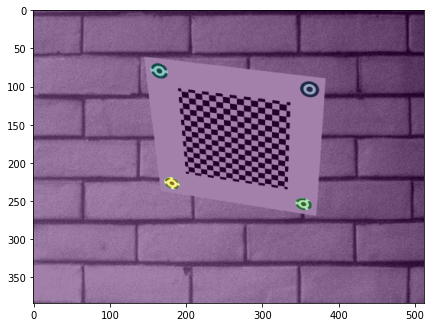

In [16]:
plt.figure(figsize=(7,7))
plt.imshow(X.squeeze(), vmin=-1, vmax=1, cmap='gray')
plt.imshow(y, vmin=0, vmax=4, alpha=0.5)

# Generate some raw files

These are useful because you can just load directly without having to format anything; these are primarily for testing inference performance and for doing 8-bit quantization calibration.

In [1]:
import sys
sys.path.append('../fiducial_detect/')

In [2]:
from fiducial_detect.data import *
from fiducial_detect.models import *

In [3]:
import torch
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from test_fast_inference.data import FormatImg

TensorRT documentation says ~500 images are pretty good for 8-bit quantization

In [4]:
num_batches = 500

In [5]:
ds_trn = RealMaskDataSet(Path('/data/fiducial_detect/trn/imgs'), 
                         tfms=Compose([FormatImg(),
                                       ToTensor()]))

In [6]:
dir_batches_trn = Path('batches_trn')
dir_batches_trn.mkdir(exist_ok=True)

In [7]:
for i in range(num_batches): 
    X,_ = ds_trn[i]
    with open(dir_batches_trn/f'X{i}.raw', 'wb') as f:
        X.numpy().tofile(f)

Do validation batches

In [4]:
ds_val = RealMaskDataSet(Path('/data/fiducial_detect/val'), 
                         tfms=Compose([FormatImg(),
                                       ToTensor()]))

In [5]:
dir_batches_val = Path('batches_val')
dir_batches_val.mkdir(exist_ok=True)

In [7]:
for i in range(len(ds_val)): 
    X,_ = ds_val[i]
    with open(dir_batches_val/f'X{i}.raw', 'wb') as f:
        X.numpy().tofile(f)

# Create TFRecord for tensorflow

In [2]:
import tensorflow as tf
    
from pathlib import Path
import matplotlib.pyplot as plt

INFO:tensorflow:Using local port 24500
INFO:tensorflow:Using local port 20487
INFO:tensorflow:Using local port 20819
INFO:tensorflow:Using local port 19940
INFO:tensorflow:Using local port 21232
INFO:tensorflow:Using local port 23628
INFO:tensorflow:Using local port 22608
INFO:tensorflow:Using local port 20537
INFO:tensorflow:Using local port 18261
INFO:tensorflow:Using local port 21720


In [3]:
def _bytes_feature(value): return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [4]:
def _float_feature(value): return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

In [5]:
def _int64_feature(value): return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [6]:
def _read_bytes(file):
    with open(file, 'rb') as f:
        arr_bytes = f.read()
    return arr_bytes

In [7]:
def _example(img_bytes, mask_bytes):
    feature = {
        'img':  _bytes_feature(img_bytes),
        'mask': _bytes_feature(mask_bytes),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

In [8]:
dir_trn_tfrecord = Path('/data/fiducial_detect/trn/tfrecord')
dir_trn_tfrecord.mkdir(exist_ok='True')

In [9]:
file_tfrecord = dir_trn_tfrecord/'trn.tfrecord'

In [10]:
dir_trn_imgs = Path('/data/fiducial_detect/trn/imgs')
files_mask = [p for p in dir_trn_imgs.glob('*.png') if p.as_posix().endswith('_mask.png')]
with tf.io.TFRecordWriter(file_tfrecord.as_posix()) as writer:
    for file_mask in files_mask:
        file_img = dir_trn_imgs/(file_mask.stem[:-5] + file_mask.suffix)
        img_bytes =  _read_bytes(file_img)
        mask_bytes = _read_bytes(file_mask)
        example = _example(img_bytes, mask_bytes)
        writer.write(example.SerializeToString())

Create dataset for training images and validation images

In [10]:
# export
def format(img, mask):
    import tensorflow as tf

    img, mask = [tf.io.decode_png(X) for X in [img, mask]]
    img, mask = [tf.cast(X, tf.float32) for X in [img, mask]]
    img  /= 255; img  *= 2; img -= 1
    mask /= 255; mask *= 4; mask = tf.round(mask); mask = tf.cast(mask, tf.int64)
    return img, mask

In [11]:
# export
def preprocess_tfrecord(serialized): 
    import tensorflow as tf
    
    features = {
        'img':  tf.io.FixedLenFeature([], tf.string),
        'mask': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(serialized, features)
    return format(example['img'], example['mask'])

In [12]:
ds_trn = (
    tf.data.TFRecordDataset((dir_trn_tfrecord/'trn.tfrecord').as_posix())
    .map(preprocess_tfrecord)
    .batch(28)
)

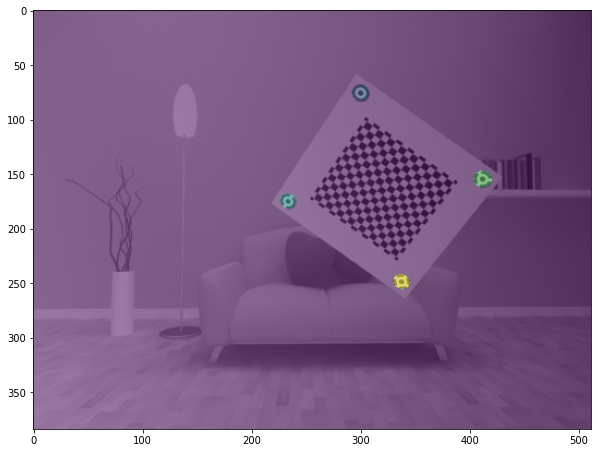

In [13]:
for idx, (img, mask) in enumerate(ds_trn.take(1)):
    plt.figure(idx, figsize=(10, 10))
    plt.imshow(img[0],  vmin=-1, vmax=1, cmap='gray')
    plt.imshow(mask[0], vmin= 0, vmax=4, alpha=0.5)

In [14]:
# export
def preprocess_file(file_mask): 
    import tensorflow as tf
    
    file_img = tf.strings.regex_replace(file_mask, '_mask', '')
    img, mask = [tf.io.read_file(file) for file in [file_img, file_mask]]
    return format(img, mask)

In [15]:
dir_val = Path('/data/fiducial_detect/val')

In [16]:
ds_val = (
    tf.data.Dataset.list_files((dir_val/'*_mask.png').as_posix(), shuffle=False)
    .map(preprocess_file)
    .batch(28)
)

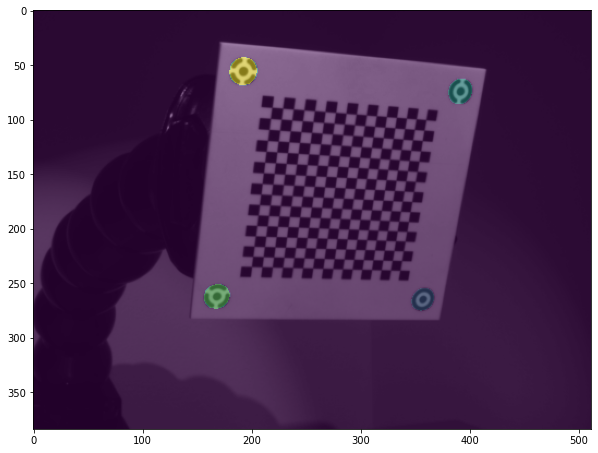

In [17]:
for idx, (img, mask) in enumerate(ds_val.take(1)):
    plt.figure(idx, figsize=(10, 10))
    plt.imshow(img[0],  vmin=-1, vmax=1, cmap='gray')
    plt.imshow(mask[0], vmin= 0, vmax=4, alpha=0.5)

In [19]:
#export
def preprocess_raw(file_raw): 
    import tensorflow as tf
    
    img = tf.io.read_file(file_raw)
    img = tf.io.decode_raw(img, tf.float32)
    return tf.reshape(img, (1, 384, 512, 1))

In [21]:
ds_raw = (
    tf.data.Dataset.list_files('batches/*.raw', shuffle=False)
    .map(preprocess_raw)
)

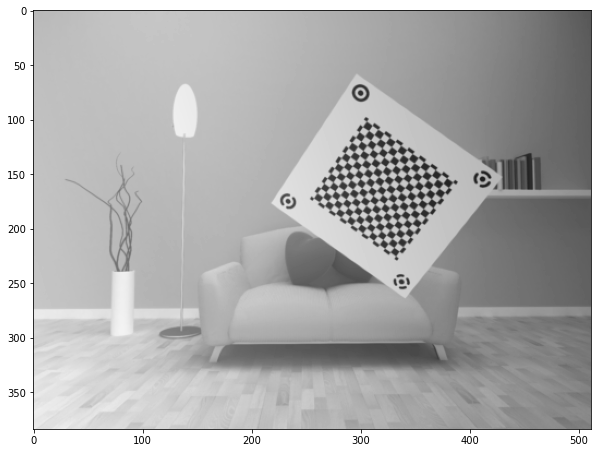

In [23]:
for img in ds_raw.take(1):
    plt.figure(idx, figsize=(10, 10))
    plt.imshow(img[0],  vmin=-1, vmax=1, cmap='gray')

# Build

In [24]:
!nbdev_build_lib --fname data.ipynb

Converted data.ipynb.
